# End to End BSS

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## train

In [7]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import numpy as np
import tqdm
from argparse import ArgumentParser

from model import WaveNet, loss_fn, align
from datasets.datasets import train_dataset, test_dataset
from params import params

# lr = 1e-2
# batch_size = 256
# epoch = 50

# device = torch.device('cuda:2')

# model = WaveNet(params=params).to(device)
# try: 
#     model.load_state_dict(torch.load('/home/wyl/projects/_BSS_latent/01_WaveNet/ckpt/ckpt.pth'))
#     print('model loaded')
# except:
#     print('model does not exist')

# train_data = train_dataset()
# test_data = test_dataset()
# data_loader = DataLoader(train_data, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

# optimizer = AdamW(model.parameters(), lr=lr, eps=1e-6)

# tqdm_epoch = tqdm.notebook.tqdm(range(epoch))

# for _ in tqdm_epoch:
#     avg_loss = 0.
#     num_items = 0
#     for train_data, truth in data_loader:
#         train_data = align(train_data.squeeze(1)).to(device)
#         truth = align(truth.squeeze(1)).to(device)

#         output = model(train_data)
#         loss = loss_fn(output, truth)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         avg_loss += loss.item() * train_data.shape[0]
#         num_items += train_data.shape[0]

#     # # Print the averaged training loss so far.
#     # tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
#     # # Update the checkpoint after each epoch of training.
#     # torch.save(model.state_dict(), '/home/wyl/projects/_BSS_latent/01_WaveNet/ckpt/ckpt.pth') 
    
#     with torch.no_grad():
        
#         test_loss = 0.
#         test_items = 0
#         for test_data, test_truth in test_loader:
#             test_data = align(test_data.squeeze(1)).to(device)
#             test_truth = align(test_truth.squeeze(1)).to(device)

#             output = model(test_data)
#             loss = loss_fn(output, test_truth)

#             test_loss += loss.item() * train_data.shape[0]
#             test_items += train_data.shape[0]

#     # print('test loss: {:5f}'.format(test_loss / test_items))
#     # Print the averaged training loss so far.
#     tqdm_epoch.set_description('Average Loss: {:5f},   Test Loss: {:5f}'.format(avg_loss / num_items, test_loss / test_items))
#     # Update the checkpoint after each epoch of training.
#     torch.save(model.state_dict(), '/home/wyl/projects/_BSS_latent/ckpt/ckpt.pth') 


## evaluate and show

In [8]:
from sklearn.decomposition import PCA, FastICA

def ICA(data):  # data shape [1, 1, length]
    # separate into three parts
    components = 3    # or 5
    data = np.array(data)
    ica = FastICA(n_components=components)
    result = None
    for lines in data:
        ica_fit = ica.fit(lines)[None, ...]
        result = ica_fit if result is None else result.append(ica_fit, axis=0)
    return result  # []

In [9]:
import torch
from model import WaveNet
import matplotlib.pyplot as plt
from datasets.datasets import train_dataset, test_dataset
from torch.utils.data import DataLoader, RandomSampler
from params import params

seed = torch.manual_seed(1001)
train_sampler = RandomSampler(train_dataset(), replacement=False, num_samples=100)
test_sampler = RandomSampler(test_dataset(), replacement=False, num_samples=100)
train_loader = DataLoader(train_dataset(), batch_size=20, sampler=train_sampler)
test_loader = DataLoader(test_dataset(), batch_size=20, shuffle=test_sampler)

train_data, train_truth = next(iter(train_loader))
test_data, test_truth = next(iter(test_loader))

randint = torch.randint(0, 20, (1,))
train_data = train_data.squeeze(1).to(torch.float32)
train_truth = train_truth.squeeze(1).to(torch.float32)

test_data = test_data.squeeze(1).to(torch.float32)
test_truth = test_truth.squeeze(1).to(torch.float32)


In [10]:
# end to end eval
model = WaveNet(params)
try: 
    model.load_state_dict(torch.load('/home/wyl/projects/_BSS_hijack/_end_to_end_compare/ckpt/ckpt.pth'))
    print('::: model loaded :::')
except:
    print('::: ckpt does not exist :::')
model.eval()

with torch.no_grad():
    train_output = model(train_data)
    test_output = model(test_data)

result_model = train_output[randint].squeeze(0)
truth_model = train_truth[randint].squeeze(0)

result_test = test_output[randint].squeeze(0)
result_truth = test_truth[randint].squeeze(0)


# # plot
# fig, axs = plt.subplots(nrows=3, ncols=2)

# axs[0, 0].plot(result_model[0])
# axs[0, 0].set_title("separated EEG")
# axs[0, 0].plot(truth_model[0])
# axs[0, 1].set_title("ground truth EEG")

# axs[1, 0].plot(result_model[1])
# axs[1, 0].set_title("separated EMG")
# axs[1, 0].plot(truth_model[1])
# axs[1, 1].set_title("ground truth EMG")

# axs[2, 0].plot(result_model[2])
# axs[2, 0].set_title("separated EOG")
# axs[2, 0].plot(truth_model[2])
# axs[2, 1].set_title("ground truth EOG")

# fig.suptitle('Comparation')

# plt.show()

# fig, axs = plt.subplots(nrows=3, ncols=2)

# axs[0, 0].plot(result_model[0])
# axs[0, 0].set_title("separated EEG")
# axs[0, 1].plot(truth_model[0])
# axs[0, 1].set_title("ground truth EEG")

# axs[1, 0].plot(result_model[1])
# axs[1, 0].set_title("separated EMG")
# axs[1, 1].plot(truth_model[1])
# axs[1, 1].set_title("ground truth EMG")

# axs[2, 0].plot(result_model[2])
# axs[2, 0].set_title("separated EOG")
# axs[2, 1].plot(truth_model[2])
# axs[2, 1].set_title("ground truth EOG")

# fig.suptitle('Comparation Method')

# plt.show()

loss_model_train = loss_fn(train_output, train_truth)
loss_model_test = loss_fn(test_output, test_truth)

print(loss_model_train)
print(loss_model_test)

::: model loaded :::
tensor(0.1080)
tensor(0.1337)


torch.Size([512])


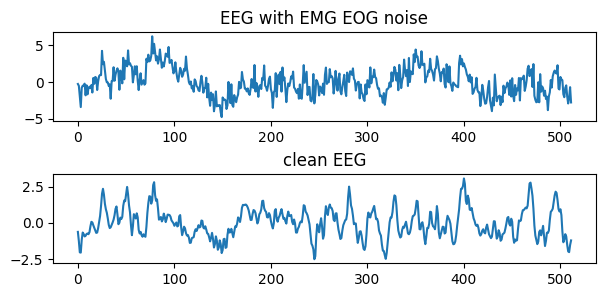

In [49]:
# data show
data = train_data[0].squeeze(0)
print(data.shape)



# fig = plt.figure(figsize=(6, 2))
# plt.plot(data)
# plt.title("EEG with EMG EOG noise")

# clean
c_data = train_truth[0][0].squeeze(0)

# fig = plt.figure(figsize=(6, 2))
# plt.plot(c_data)
# plt.title("clean EEG")

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3))
axs[0].plot(data)
axs[1].plot(c_data)
axs[0].set_title("EEG with EMG EOG noise")
axs[1].set_title("clean EEG")
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.6)

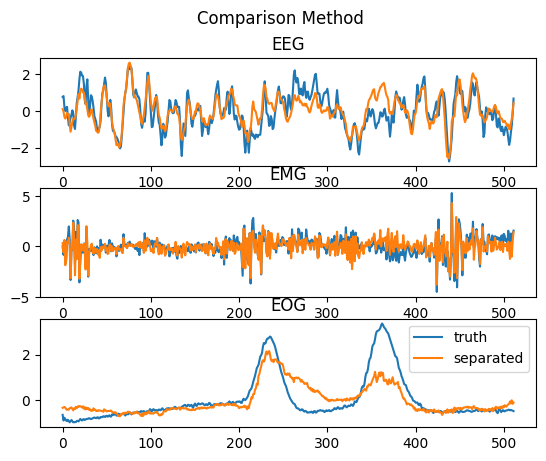

In [22]:
# plot
fig, axs = plt.subplots(nrows=3, ncols=1)

axs[0].plot(result_truth[0])
axs[0].plot(result_test[0])
axs[0].set_title("EEG")

# axs[0].set_title("ground truth EEG")

axs[1].plot(result_truth[1])
axs[1].plot(result_test[1])
axs[1].set_title("EMG")

# axs[1].set_title("ground truth EMG")

axs[2].plot(result_truth[2], label='truth')
axs[2].plot(result_test[2], label='separated')
axs[2].set_title("EOG")
axs[2].legend()

# axs[2].set_title("ground truth EOG")

fig.suptitle('Comparison Method')

plt.show()

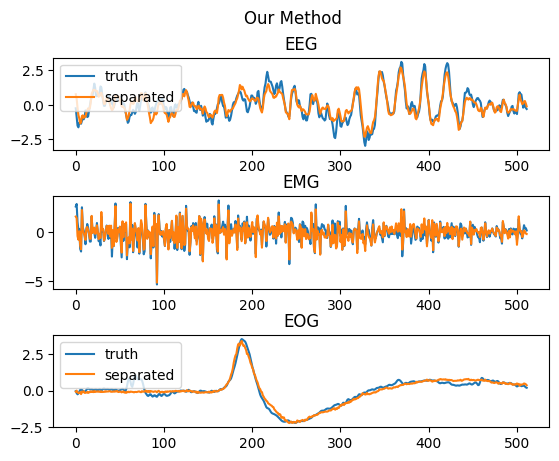

In [20]:
# plot
fig, axs = plt.subplots(nrows=3, ncols=1)

axs[0].plot(truth_model[0], label='truth')
axs[0].plot(result_model[0], label='separated')
axs[0].set_title("EEG")

# axs[0].set_title("ground truth EEG")
axs[0].legend()

axs[1].plot(truth_model[1])
axs[1].plot(result_model[1])
axs[1].set_title("EMG")

# axs[1].set_title("ground truth EMG")
axs[2].plot(truth_model[2], label='truth' )
axs[2].plot(result_model[2], label='separated')
axs[2].set_title("EOG")
axs[2].legend()
# axs[2].set_title("ground truth EOG")

plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.5)

fig.suptitle('Our Method')

plt.show()

In [13]:
# ica eval
# import numpy as np
# from model import loss_fn

# train_ica = ICA(train_data)
# train_loss = loss_fn(train_ica, train_truth)

# test_ica = ICA(test_data)
# test_loss = loss_fn(test_ica, test_truth)